Dataset Shape: (1000, 9)
   CustomerId  Age  Gender    Balance  EstimatedSalary  NumOfProducts  \
0           1   56    Male  212801.73         30322.86              1   
1           2   69    Male  123786.63        115094.54              3   
2           3   46    Male  120146.64         44363.55              4   
3           4   32  Female  148101.95        131563.02              3   
4           5   60    Male  206170.24        126478.26              2   

   CreditScore  IsActiveMember  Exited  
0          847               0       1  
1          568               1       0  
2          458               0       1  
3          628               0       0  
4          523               0       1  

===== Logistic Regression =====
Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       105
           1       0.87      0.83      0.85        95

    accuracy                           0.86       200


c:\Users\Shravya H Jain\Desktop\Churn\Pingbix_company_interview\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== XGBoost =====
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       105
           1       0.97      0.97      0.97        95

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Confusion Matrix:
 [[102   3]
 [  3  92]]

Best Model: XGBoost with Accuracy = 0.9700
✅ Best model and scaler saved successfully!


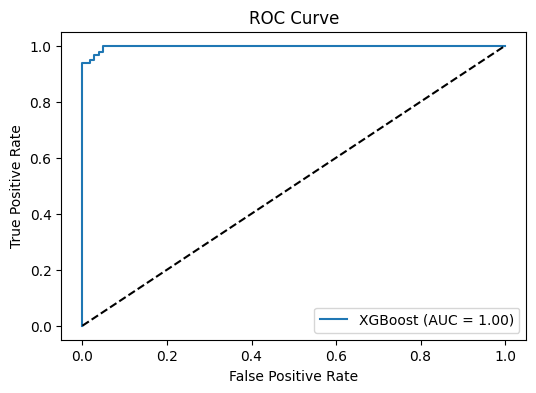

In [21]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


df = pd.read_csv("bank_churn_dataset.csv")

print("Dataset Shape:", df.shape)
print(df.head())


if "CustomerId" in df.columns:
    df = df.drop(["CustomerId"], axis=1)
if "Surname" in df.columns:
    df = df.drop(["Surname"], axis=1)

# Encode Gender
if "Gender" in df.columns:
    le = LabelEncoder()
    df["Gender"] = le.fit_transform(df["Gender"])  # Male=1, Female=0

# Features & Target
X = df.drop("Exited", axis=1)
y = df["Exited"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
best_model = None
best_score = 0
best_name = ""

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    if acc > best_score:
        best_score = acc
        best_model = model
        best_name = name

print("\n========================")
print(f"Best Model: {best_name} with Accuracy = {best_score:.4f}")
print("========================")


joblib.dump(best_model, "best_churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")   # Save scaler for future preprocessing

print("✅ Best model and scaler saved successfully!")


y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"{best_name} (AUC = {auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
